### Load Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from nltk.sentiment import SentimentIntensityAnalyzer

### Load the Dataset

In [3]:
listings = pd.read_csv('listings.csv')

# Task 1: Data Pre-processing

The main focus of this task is to remove the irrelevant columns and values to improve model's prediction accuracy. In order to do so, we have to carefully analyze the columns and data first.

### 1) Deciding which columns to work with

In [4]:
print(listings.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

As we can see there are so many columns in the given dataset, we will select the columns, those can potentially affect the property's price

In [5]:
columns_of_interest = ['id', 'name', 'description', 'neighbourhood', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 
                       'bedrooms', 'beds', 'amenities', 'number_of_reviews', 'review_scores_rating', 'price']
listings_updated = listings[columns_of_interest]

In [6]:
listings_updated.head(2)

,id,name,description,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,number_of_reviews,review_scores_rating,price
0,894708633943425209,Rental unit in Antwerpen · 1 bedroom · 4 beds ...,A bright and beautiful newly renovated apartme...,"Antwerpen, Vlaams Gewest, Belgium",51.223309,4.402095,Entire rental unit,Entire home/apt,8,NaN,1.0,4.0,"[""Extra pillows and blankets"", ""Conditioner"", ...",2,5.0,$56.00
1,741093042494325959,Serviced apartment in Antwerpen · Studio · 1 b...,Elegant ingerichte kamer in het hart van Antwe...,NaN,51.224110,4.398240,Private room in serviced apartment,Private room,2,NaN,NaN,1.0,"[""Wifi"", ""Fire extinguisher"", ""Dedicated works...",0,NaN,$142.00


In [11]:
type(listings_updated['price'][0])


str

### 2) Cleaning prices and dealing with missing values

Before feeding data to the prediction model, it is important to clean the data first so that it can accurately fit the model's objective. In the given dataset, there are numerous cells those have null values. Our goal is to remove that irrelevant information and improve model's prediction and processing speed.

##### Change the currency to float values

In [12]:
print(listings_updated.price[:5])

0     $56.00
1    $142.00
2     $40.00
3     $70.00
4     $35.00
Name: price, dtype: object


In [13]:
print(listings_updated.price.dtype)

object


As we cans see above, the column "price" is having a string value with "$" in it. We need to remove that sign and convert that colun value to float one, in order to apply Machine Learning prediction algorith as given in the objective.

In [14]:
price_col = listings_updated['price'].replace('[\$,]', '', regex=True).astype(float)

In [15]:
listings_updated.loc[:, 'price'] = price_col

C:\Users\AMAN\AppData\Local\Temp\ipykernel_13384\3882805785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_updated.loc[:, 'price'] = price_col
C:\Users\AMAN\AppData\Local\Temp\ipykernel_13384\3882805785.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  listings_updated.loc[:, 'price'] = price_col


In [16]:
print(listings_updated.price.dtype)
print(listings_updated.price[:5])

float64
0     56.0
1    142.0
2     40.0
3     70.0
4     35.0
Name: price, dtype: float64


In [17]:
listings_updated.loc[:,['name','price']].head(3)

,name,price
0,Rental unit in Antwerpen · 1 bedroom · 4 beds ...,56.0
1,Serviced apartment in Antwerpen · Studio · 1 b...,142.0
2,Home in Antwerpen · ★4.75 · 1 bedroom · 1 bed ...,40.0


##### Number of rows and columns in dataset before cleaning

In [21]:
rows, columns = listings_updated.shape
print("Rows:", rows)
print("Columns: ", columns)

Rows: 2702
Columns:  16


- Check the number of null values in each column

In [24]:
print(listings_updated.isnull().sum())

id                         0
name                       0
description               61
neighbourhood           1225
latitude                   0
longitude                  0
property_type              0
room_type                  0
accommodates               0
bathrooms               2702
bedrooms                 473
beds                      21
amenities                  0
number_of_reviews          0
review_scores_rating     438
price                      0
dtype: int64


- In oredr to deal with null values, we have two options, either to remove those records or fill them with assumed values.
- As we can see in the summary above, "bathroom" column has no record for all 2702 rows. Hence, we can exclude that column.

In [25]:
listings_cleaned = listings_updated.drop(columns=["bathrooms"])
print(listings_cleaned.shape)

(2702, 15)


- Let's fill the "bedrooms", "beds" with the most repeated values

In [26]:
# Calculate the mode
bedrooms_mode = listings_cleaned['bedrooms'].mode().iloc[0]
beds_mode = listings_cleaned['beds'].mode().iloc[0]

In [27]:
print(bedrooms_mode)

1.0


In [28]:
print(beds_mode)

1.0


##### Fill the Null values

In [29]:
listings_cleaned["bedrooms"].fillna(bedrooms_mode, inplace=True)
listings_cleaned["beds"].fillna(beds_mode, inplace=True)

In [30]:
print(listings_cleaned.isnull().sum())

id                         0
name                       0
description               61
neighbourhood           1225
latitude                   0
longitude                  0
property_type              0
room_type                  0
accommodates               0
bedrooms                   0
beds                       0
amenities                  0
number_of_reviews          0
review_scores_rating     438
price                      0
dtype: int64


As we can see in the summary, those columns no longer have any missing values in them

- Let's fill the "review_scores_rating" with the average value of that column

In [31]:
listings_cleaned['review_scores_rating'].fillna(listings_cleaned.review_scores_rating.mean(), inplace=True)

In [32]:
print(listings_cleaned.isnull().sum())

id                         0
name                       0
description               61
neighbourhood           1225
latitude                   0
longitude                  0
property_type              0
room_type                  0
accommodates               0
bedrooms                   0
beds                       0
amenities                  0
number_of_reviews          0
review_scores_rating       0
price                      0
dtype: int64


##### Delete the records, those have still have null values

The code below, will remove all the rows, where "description" and "neighbourhood" has no value. We cannot calculate mean, median or mode for these columns, as they are not numerical ones.

In [33]:
listings_cleaned.dropna(inplace=True)

In [34]:
listings_cleaned.isnull().sum()

id                      0
name                    0
description             0
neighbourhood           0
latitude                0
longitude               0
property_type           0
room_type               0
accommodates            0
bedrooms                0
beds                    0
amenities               0
number_of_reviews       0
review_scores_rating    0
price                   0
dtype: int64

##### Number of rows and columns in dataset before cleaning

In [35]:
rows, columns = listings_cleaned.shape
print("Rows:", rows)
print("Columns: ", columns)

Rows: 1447
Columns:  15


# Task 2: Exploratory Data Analysis (EDA) with Data Visualization

### 3) Price column visualization

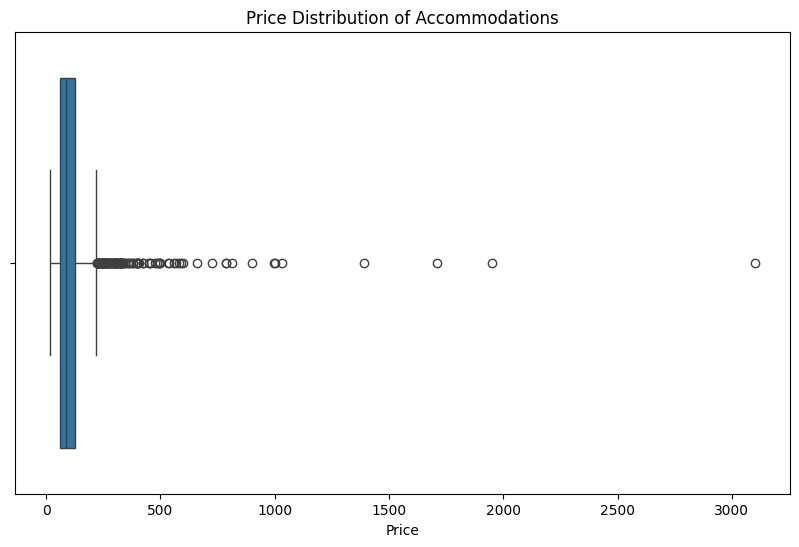

In [36]:
# Boxplot for price distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='price', data=listings_cleaned)
plt.title('Price Distribution of Accommodations')
plt.xlabel('Price')
plt.show()

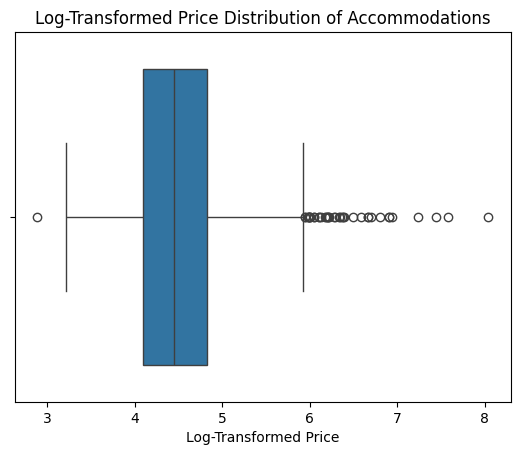

In [37]:
# Log-transform the 'price' column
listings_cleaned['log_price'] = np.log1p(listings_cleaned['price'])

# Create a boxplot for log-transformed prices
# plt.figure(figsize=(8, 6))
sns.boxplot(x='log_price', data=listings_cleaned)
plt.title('Log-Transformed Price Distribution of Accommodations')
plt.xlabel('Log-Transformed Price')
plt.show()


- We can adjust the whiskers' range to include a specific percentage of the data, excluding extreme outliers.

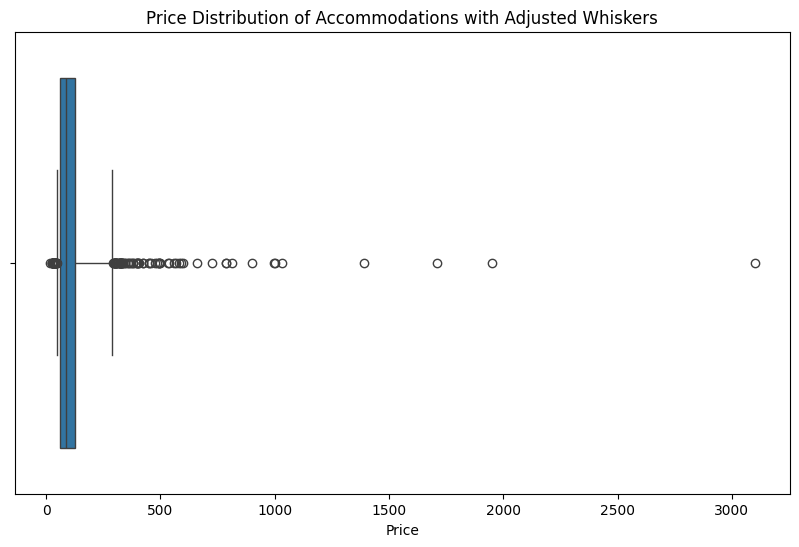

In [38]:
# Create a boxplot with adjusted whiskers
plt.figure(figsize=(10, 6))
sns.boxplot(x='price', data=listings_cleaned, whis=[5, 95])  # Adjust the whiskers as needed
plt.title('Price Distribution of Accommodations with Adjusted Whiskers')
plt.xlabel('Price')
plt.show()

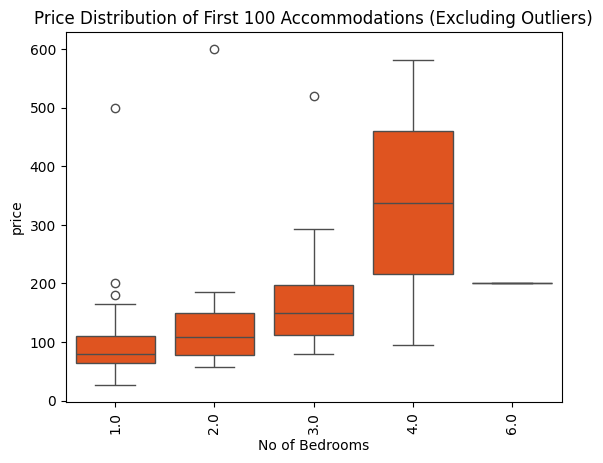

In [39]:
# Remove extreme outliers (adjust threshold as needed)
listings_no_outliers = listings_updated[listings_updated['price'] < 1000].head(100)
sns.boxplot( x=listings_no_outliers["bedrooms"], y=listings_no_outliers["price"], color='orangered');
plt.title('Price Distribution of First 100 Accommodations (Excluding Outliers)')
plt.xlabel('No of Bedrooms')
plt.xticks(rotation=90)
plt.show()

### 4) Accommodation distribution on maps

- Plot accommodation based on longitude and latitude value

In [40]:
mean_latitude = listings_cleaned['latitude'].mean()
mean_longitude = listings_cleaned['longitude'].mean()

# Create a map
mp = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=10)

# Add markers for each accommodation
for index, row in listings_cleaned.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(mp)

# Save or display the map
mp.save('accommodation_distribution_map.html')

Above Code has created an HTML file in my project directory, I will display the result using Iframe

In [41]:
from IPython.display import IFrame
html_path = 'accommodation_distribution_map.html'
width = 800
height = 400
# Display the HTML page in the notebook
IFrame(html_path, width=width, height=height)

### 5) Summarize the number of accommodations in each market/ each region

In [42]:
accommodations_by_region = listings_cleaned.groupby('neighbourhood')['id'].count()
print(accommodations_by_region)

neighbourhood
2018 Antwerpen, Belgium                      1
Antwerp, Belgium                            10
Antwerp, Flanders, Belgium                  27
Antwerp, Flemish Region, Belgium            11
Antwerp, Vlaams Gewest, Belgium              1
Antwerp, Vlaanderen, Belgium                 1
Antwerpen, Antwerp, Belgium                  1
Antwerpen, Belgium                          18
Antwerpen, Flanders, Belgium                 1
Antwerpen, Flanders/Vlaanderen, Belgium      1
Antwerpen, Vlaams Gewest, Belgium          718
Antwerpen, Vlaanderen, Belgium             653
Berchem, Belgium                             1
Borgerhout, Vlaanderen, Belgium              1
Brasschaat, Vlaams Gewest, Belgium           1
Ekeren , Vlaanderen, Belgium                 1
Name: id, dtype: int64


### 6) Summarize the mean price of accommodations in each market/ each region

In [46]:
mean_price_of_region = listings_cleaned.groupby('neighbourhood')['price']
mean_price_of_region.mean()

neighbourhood
2018 Antwerpen, Belgium                     79.000000
Antwerp, Belgium                           219.400000
Antwerp, Flanders, Belgium                 123.481481
Antwerp, Flemish Region, Belgium           144.727273
Antwerp, Vlaams Gewest, Belgium            311.000000
Antwerp, Vlaanderen, Belgium               140.000000
Antwerpen, Antwerp, Belgium                 56.000000
Antwerpen, Belgium                         113.722222
Antwerpen, Flanders, Belgium                45.000000
Antwerpen, Flanders/Vlaanderen, Belgium     79.000000
Antwerpen, Vlaams Gewest, Belgium          122.736769
Antwerpen, Vlaanderen, Belgium             110.272588
Berchem, Belgium                           146.000000
Borgerhout, Vlaanderen, Belgium             91.000000
Brasschaat, Vlaams Gewest, Belgium         131.000000
Ekeren , Vlaanderen, Belgium                50.000000
Name: price, dtype: float64

# Task 3: Building the Accommodation Prediction Model

##### DEAL WITH NON-NUMERIC DATA

In [49]:
# print(listings_cleaned.dtypes)
columns_to_drop = ['name', 'description', 'amenities']
numeric_listings = listings_cleaned.drop(columns=columns_to_drop)
numeric_listings
print(numeric_listings.neighbourhood.unique())

['Antwerpen, Vlaams Gewest, Belgium' 'Antwerpen, Vlaanderen, Belgium'
 'Antwerp, Flemish Region, Belgium' 'Antwerp, Flanders, Belgium'
 'Antwerpen, Belgium' 'Antwerp, Belgium' '2018 Antwerpen, Belgium'
 'Borgerhout, Vlaanderen, Belgium' 'Antwerp, Vlaams Gewest, Belgium'
 'Ekeren , Vlaanderen, Belgium' 'Antwerpen, Flanders/Vlaanderen, Belgium'
 'Antwerpen, Flanders, Belgium' 'Antwerp, Vlaanderen, Belgium'
 'Antwerpen, Antwerp, Belgium' 'Berchem, Belgium'
 'Brasschaat, Vlaams Gewest, Belgium']


##### Encode categorical columns

neighbourhood', 'property_type', 'room_type' columns appears to be valuable to predict price of the property. So, we will convert those columns to numeric data using get_dummies(). This function adds columns/features to the daatset based on the unique values.

In [50]:
print("Shape before encoding: ", numeric_listings.shape)

Shape before encoding:  (1447, 13)


In [51]:
numeric_listings = pd.get_dummies(numeric_listings, columns=['neighbourhood', 'property_type', 'room_type'], drop_first=True)

In [52]:
print("Shape after encoding: ", numeric_listings.shape)

Shape after encoding:  (1447, 54)


In [55]:
numeric_listings.columns[10:]

Index(['neighbourhood_Antwerp, Belgium',
       'neighbourhood_Antwerp, Flanders, Belgium',
       'neighbourhood_Antwerp, Flemish Region, Belgium',
       'neighbourhood_Antwerp, Vlaams Gewest, Belgium',
       'neighbourhood_Antwerp, Vlaanderen, Belgium',
       'neighbourhood_Antwerpen, Antwerp, Belgium',
       'neighbourhood_Antwerpen, Belgium',
       'neighbourhood_Antwerpen, Flanders, Belgium',
       'neighbourhood_Antwerpen, Flanders/Vlaanderen, Belgium',
       'neighbourhood_Antwerpen, Vlaams Gewest, Belgium',
       'neighbourhood_Antwerpen, Vlaanderen, Belgium',
       'neighbourhood_Berchem, Belgium',
       'neighbourhood_Borgerhout, Vlaanderen, Belgium',
       'neighbourhood_Brasschaat, Vlaams Gewest, Belgium',
       'neighbourhood_Ekeren , Vlaanderen, Belgium',
       'property_type_Entire condo', 'property_type_Entire guest suite',
       'property_type_Entire guesthouse', 'property_type_Entire home',
       'property_type_Entire loft', 'property_type_Entire place'

### 7) Choose a supervised model such as Xgboost, ANNs and other models to implement your price predictor

##### First we will split the features and target column

In [ ]:
# print(numeric_listings.columns)

In [56]:
columns_to_exclude = ['id', 'latitude', 'longitude' ,'price', 'log_price']
X = numeric_listings.drop(columns=columns_to_exclude)
Y = numeric_listings['price']

In [57]:
X.columns

Index(['accommodates', 'bedrooms', 'beds', 'number_of_reviews',
       'review_scores_rating', 'neighbourhood_Antwerp, Belgium',
       'neighbourhood_Antwerp, Flanders, Belgium',
       'neighbourhood_Antwerp, Flemish Region, Belgium',
       'neighbourhood_Antwerp, Vlaams Gewest, Belgium',
       'neighbourhood_Antwerp, Vlaanderen, Belgium',
       'neighbourhood_Antwerpen, Antwerp, Belgium',
       'neighbourhood_Antwerpen, Belgium',
       'neighbourhood_Antwerpen, Flanders, Belgium',
       'neighbourhood_Antwerpen, Flanders/Vlaanderen, Belgium',
       'neighbourhood_Antwerpen, Vlaams Gewest, Belgium',
       'neighbourhood_Antwerpen, Vlaanderen, Belgium',
       'neighbourhood_Berchem, Belgium',
       'neighbourhood_Borgerhout, Vlaanderen, Belgium',
       'neighbourhood_Brasschaat, Vlaams Gewest, Belgium',
       'neighbourhood_Ekeren , Vlaanderen, Belgium',
       'property_type_Entire condo', 'property_type_Entire guest suite',
       'property_type_Entire guesthouse', 'prop

In [58]:
print(Y[:5])

0      56.0
9      56.0
16     38.0
37    581.0
45     80.0
Name: price, dtype: float64


##### Split the data to training and testing sets

Let's keep 80% of data for training and rest 20% for testing, as mentioned in the requirement

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [61]:
print("Original data (rows, columns): ", X.shape)
print("Training data (rows, columns): ", X_train.shape)
print("Testing data (rows, columns): ", X_test.shape)

Original data (rows, columns):  (1447, 49)
Training data (rows, columns):  (1157, 49)
Testing data (rows, columns):  (290, 49)


In order to make predictive model on the given dataset using supervised model. We need to remove or convert all the columns, those are having string values in them. In simple words, machine learning model will accept numeric data only

##### CREATE AND TRAIN THE MODEL

In [62]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##### MODEL VALIDATION

In [67]:
from sklearn.metrics import r2_score

# Predictions on training set
y_train_pred = model.predict(X_train)
# Calculate R^2 score for training set
r2_train = r2_score(y_train, y_train_pred)
print(f"Training R^2 Score: {r2_train}")


Training R^2 Score: 0.9829928411868138


### 8) Perform an analysis to discuss what kinds features are most related to the accommodation price

In [65]:
feature_importance = model.feature_importances_
print(feature_importance)

[2.16433965e-02 3.54780465e-01 1.83412842e-02 1.95220802e-02
 1.01227779e-02 7.24851678e-04 4.31323564e-03 1.57782640e-02
 0.00000000e+00 0.00000000e+00 1.04970916e-03 9.60945850e-04
 0.00000000e+00 1.07794374e-04 6.05359161e-03 6.71159988e-03
 2.81486381e-03 0.00000000e+00 7.26134926e-02 0.00000000e+00
 5.25651919e-03 0.00000000e+00 3.34265147e-04 6.24218807e-02
 1.02499845e-02 3.65824380e-04 1.93807371e-02 1.62586793e-01
 1.73878949e-02 5.96731086e-04 0.00000000e+00 0.00000000e+00
 8.04860727e-04 1.31359491e-02 1.26780433e-04 1.76346395e-03
 6.14718185e-04 3.33086681e-03 3.46796308e-03 8.35463114e-04
 6.08764915e-03 1.15675945e-03 1.76968891e-02 7.20587000e-02
 3.39194760e-02 0.00000000e+00 0.00000000e+00 9.20375809e-04
 2.99611539e-02]


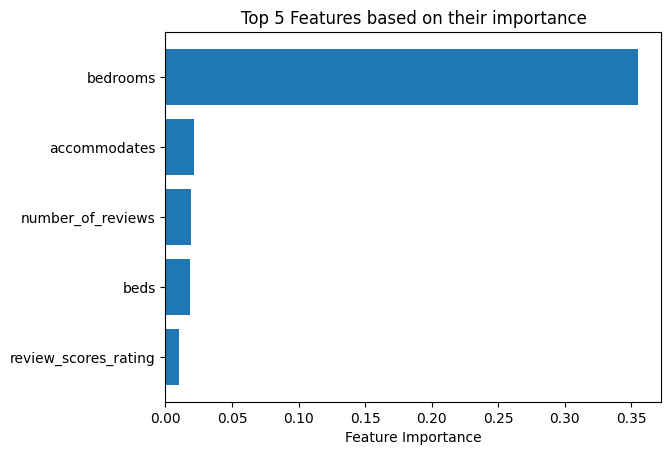

In [66]:
# Sort the features based on importance
indices = np.argsort(feature_importance[:5])
feature_names = X_train.columns[:5]
# Plotting
# plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), feature_importance[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 5 Features based on their importance')
plt.show()

# Task 4（Advanced tasks)：Sentiment analysis

In [68]:
reviews = pd.read_csv('reviews.csv')
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,50904,31511792,2015-05-06,19482395,Jihae,Karin’s “Aplace” is absolutely beautiful and c...
1,50904,470101024356869935,2021-10-10,333559,Emilie,"Karin is a wonderful host, she was really help..."
2,50904,627287279025726941,2022-05-15,32701854,Marie-Lou,The location is super super nice! Karin was al...
3,224682,933043,2012-02-20,1422043,Hiske & Erik,"Perfect location for exploring the city, close..."
4,224682,970457,2012-03-05,1493171,Paolo,"Muriel was such a fantastic host, extremely he..."


In [69]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\AMAN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 9) Perform the sentiment analysis for the review comments

In [70]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [72]:
# Define a function to calculate sentiment score
def calculate_sentiment_score(comment):
    if isinstance(comment, str):
        return sia.polarity_scores(comment)['compound']
    else:
        return None  # we can use any default value for non-string values

# Apply the sentiment analysis function to the 'comments' column
reviews['sentiment_score'] = reviews['comments'].apply(calculate_sentiment_score)


In [73]:
print(reviews.tail(2))

               listing_id                  id        date  reviewer_id  \
97123  975154238474532959  977398882312709986  2023-09-10    384546438   
97124  977985082084304366  981701740613077893  2023-09-16    210133725   

      reviewer_name                                           comments  \
97123          Sara                             Everything was good 👍🏻   
97124           Liv  Die Lage der Wohnung war perfekt für unseren S...   

       sentiment_score  
97123           0.4404  
97124          -0.9136  


In [74]:
positive_reviews = reviews[reviews['sentiment_score'] > 0]
negative_reviews = reviews[reviews['sentiment_score'] < 0]

In [75]:
print(positive_reviews.comments[:4])

0    Karin’s “Aplace” is absolutely beautiful and c...
1    Karin is a wonderful host, she was really help...
2    The location is super super nice! Karin was al...
3    Perfect location for exploring the city, close...
Name: comments, dtype: object


In [78]:
print(negative_reviews.comments[-4:])

97111    Die Wohnung ist ideal für einen Städtetrip zu ...
97116    Wir können die Wohnung nicht empfehlen! Es war...
97122    Gute Unterkunft in toller Lage. Wenige Minuten...
97124    Die Lage der Wohnung war perfekt für unseren S...
Name: comments, dtype: object


In [ ]:
print("Number of positive reviews/comments: ", len(positive_reviews))
print("Number of negative reviews/comments: ", len(negative_reviews))

### 10) Analysis of the reasons why people like and dislike the accommodations (open question)

##### Positive Aspects (Why People Like the Accommodations):

- <b>Positive Interactions with the Host:</b> Described as helpful, kind, kind, and simple, guests love these types of hosts.
- <b>Convenient Location:</b> Being close to important landmarks, stores, pubs, and eateries is appreciated.
- <b>Beautiful Furnishings:</b> It appears that visitors appreciate well-furnished rooms with sophisticated accents and a blend of retro and modern design.
- <b>Comfort and Amenities:</b> When lodgings are roomy, cosy, and furnished with everything you need, guests are sure to leave positive reviews.
- <b>Flexibility and Consideration:</b> Guests are more likely to give positive feedback to hosts who are flexible, letting them stay late on the day of departure, and who provide thoughtful touches, such well-stocked refrigerators.
- <b>Simple Communication:</b> We like accommodations with hosts who make it simple and stress-free to communicate.

### Areas for Improvement (Potential Dislikes):

- <b>Noise Problems:</b> The fact that noise disruptions are mentioned suggests that this may be something people detest.- <b>
Potential Maintenance Concerns</b>: Although most reviews compliment the accommodations, there may be maintenance problems that go unnoticed that could result in unfavourable review.
.- <b>
No Explicitly Negative Feedbac</b>k: The remarks that have been provided are mainly positive, and there isn't any direct criticism. It's important to remember that visitors may not always be so vocal about their dislikes in their reviews.


